<a href="https://colab.research.google.com/github/ruben-28/VE_Training/blob/main/VE_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi


Wed Dec 31 19:26:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip -q install "tensorflow==2.19.0" "numpy==2.0.2" "scipy==1.14.1" "scikit-learn==1.6.1"
!pip -q install -U opencv-python mediapipe tqdm matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 140.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
import os
os.kill(os.getpid(), 9)


In [1]:
import tensorflow as tf, numpy as np, scipy, sklearn
import mediapipe as mp, cv2

print("TF:", tf.__version__)
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)
print("Sklearn:", sklearn.__version__)
print("MediaPipe:", mp.__version__)
print("OpenCV:", cv2.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))


TF: 2.19.0
NumPy: 2.0.2
SciPy: 1.14.1
Sklearn: 1.6.1
MediaPipe: 0.10.31
OpenCV: 4.12.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
%%bash
mkdir -p /content/data/IMAGES_ALL
unzip -q /content/IMAGES_ALL.zip -d /content/data/IMAGES_ALL

# Corrige le double dossier si besoin
if [ -d "/content/data/IMAGES_ALL/IMAGES_ALL" ]; then
  mv /content/data/IMAGES_ALL/IMAGES_ALL/* /content/data/IMAGES_ALL/
  rmdir /content/data/IMAGES_ALL/IMAGES_ALL
fi

echo "Root:"
ls /content/data/IMAGES_ALL | head


Root:
FER2013
RAFDB


In [3]:
%%writefile build_dataset.py
from pathlib import Path
import random, shutil, re
from collections import defaultdict

SRC = Path("/content/data/IMAGES_ALL")
DST = Path("/content/data/DATASET_FINAL")

CLASSES = ["angry","disgust","fear","happy","neutral","sad","surprise"]
ALIASES = {
    "angry":   ["angry", "anger", "ang", "mad"],
    "disgust": ["disgust", "disgusted", "disg"],
    "fear":    ["fear", "fearful", "scared", "afr"],
    "happy":   ["happy", "happiness", "smile", "joy"],
    "neutral": ["neutral", "neu", "normal"],
    "sad":     ["sad", "sadness", "unhappy"],
    "surprise":["surprise", "surprised", "surpr"]
}
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}
SEED = 42

def norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return s.strip()

def label_from_text(text: str):
    t = norm(text)
    for cls, words in ALIASES.items():
        for w in words:
            if re.search(rf"\b{re.escape(w)}\b", t):
                return cls
    return None

def guess_label(path: Path):
    lab = label_from_text(path.name)
    if lab:
        return lab
    parts = []
    for p in path.parents:
        parts.append(p.name)
        if p == SRC:
            break
    return label_from_text(" ".join(parts))

def ensure_structure():
    for split in ["train","val","test"]:
        for c in CLASSES:
            (DST/split/c).mkdir(parents=True, exist_ok=True)

def split_items(items):
    random.seed(SEED)
    random.shuffle(items)
    n = len(items)
    tr = int(n*0.7)
    va = int(n*0.15)
    return {
        "train": items[:tr],
        "val": items[tr:tr+va],
        "test": items[tr+va:]
    }

def safe_copy(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        dst = dst.with_name(dst.stem + f"__dup{random.randint(0,999999)}" + dst.suffix)
    shutil.copy2(src, dst)

def main():
    ensure_structure()

    all_imgs = []
    for p in SRC.rglob("*"):
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            lab = guess_label(p)
            if lab in CLASSES:
                all_imgs.append((p, lab))

    print("Labellisées:", len(all_imgs))
    if not all_imgs:
        print("Aucune image labellisée -> structure différente.")
        return

    by_class = defaultdict(list)
    for p, lab in all_imgs:
        by_class[lab].append(p)

    for lab, imgs in by_class.items():
        splits = split_items(imgs)
        for split, files in splits.items():
            for f in files:
                safe_copy(f, DST/split/lab/f.name)

    print("Done ->", DST)

if __name__ == "__main__":
    main()


Writing build_dataset.py


In [4]:
!python build_dataset.py


Labellisées: 77579
Done -> /content/data/DATASET_FINAL


In [5]:
%%bash
for c in angry disgust fear happy neutral sad surprise; do
  echo "$c train: $(ls /content/data/DATASET_FINAL/train/$c | wc -l)"
done


angry train: 7636
disgust train: 4552
fear train: 7753
happy train: 10461
neutral train: 8507
sad train: 8423
surprise train: 6970


In [6]:
%%bash
mkdir -p /content/models
wget -q -O /content/models/blaze_face_short_range.tflite \
  "https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite"
ls -lh /content/models/blaze_face_short_range.tflite


-rw-r--r-- 1 root root 225K Apr 26  2023 /content/models/blaze_face_short_range.tflite


In [7]:
%%writefile crop_faces_tasks.py
from pathlib import Path
import cv2
import mediapipe as mp
from tqdm import tqdm
import random

SRC_ROOT = Path("/content/data/DATASET_FINAL")
DST_ROOT = Path("/content/data/DATASET_CROPPED")
MODEL_PATH = "/content/models/blaze_face_short_range.tflite"

IMG_SIZE = (224, 224)
MARGIN = 0.25
MIN_CONF = 0.55
SPLITS = ["train","val","test"]
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}

def clamp(v, lo, hi): return max(lo, min(hi, v))

def ensure_dirs():
    for split in SPLITS:
        sdir = SRC_ROOT/split
        if not sdir.exists(): continue
        for cls in sdir.iterdir():
            if cls.is_dir():
                (DST_ROOT/split/cls.name).mkdir(parents=True, exist_ok=True)

def crop_with_box(img_bgr, x1, y1, bw, bh):
    h, w = img_bgr.shape[:2]
    mx, my = int(bw*MARGIN), int(bh*MARGIN)
    x1 = clamp(x1-mx, 0, w-1)
    y1 = clamp(y1-my, 0, h-1)
    x2 = clamp(x1+bw+2*mx, 1, w)
    y2 = clamp(y1+bh+2*my, 1, h)
    crop = img_bgr[y1:y2, x1:x2]
    if crop.size == 0: return None
    return cv2.resize(crop, IMG_SIZE, interpolation=cv2.INTER_AREA)

def main():
    ensure_dirs()

    BaseOptions = mp.tasks.BaseOptions
    FaceDetector = mp.tasks.vision.FaceDetector
    FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
    RunningMode = mp.tasks.vision.RunningMode

    options = FaceDetectorOptions(
        base_options=BaseOptions(model_asset_path=MODEL_PATH),
        running_mode=RunningMode.IMAGE,
        min_detection_confidence=MIN_CONF
    )

    total=kept=failed=0

    with FaceDetector.create_from_options(options) as detector:
        for split in SPLITS:
            sdir = SRC_ROOT/split
            if not sdir.exists(): continue

            for cls_dir in sorted([d for d in sdir.iterdir() if d.is_dir()]):
                out_dir = DST_ROOT/split/cls_dir.name
                imgs=[]
                for ext in IMG_EXTS:
                    imgs += list(cls_dir.rglob(f"*{ext}"))

                for p in tqdm(imgs, desc=f"{split}/{cls_dir.name}", leave=False):
                    total += 1
                    img = cv2.imread(str(p))
                    if img is None:
                        failed += 1
                        continue

                    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

                    res = detector.detect(mp_image)
                    if not res.detections:
                        failed += 1
                        continue

                    best = max(res.detections, key=lambda d: d.categories[0].score)
                    score = best.categories[0].score
                    if score < MIN_CONF:
                        failed += 1
                        continue

                    bb = best.bounding_box
                    crop = crop_with_box(img, bb.origin_x, bb.origin_y, bb.width, bb.height)
                    if crop is None:
                        failed += 1
                        continue

                    out_path = out_dir / p.name
                    if out_path.exists():
                        out_path = out_dir / f"{p.stem}__{random.randint(0,999999)}{p.suffix}"
                    cv2.imwrite(str(out_path), crop)
                    kept += 1

    print("Total images:", total)
    print("Cropped kept:", kept)
    print("Failed/no face:", failed)
    print("Output:", DST_ROOT)

if __name__ == "__main__":
    main()


Writing crop_faces_tasks.py


In [8]:
!python crop_faces_tasks.py


2025-12-31 19:28:16.242159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767209296.263484    1642 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767209296.270153    1642 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767209296.285061    1642 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767209296.285092    1642 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767209296.285096    1642 computation_placer.cc:177] computation placer alr

In [9]:
import tensorflow as tf
import numpy as np
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

tf.keras.mixed_precision.set_global_policy("mixed_float16")

DATA_ROOT = Path("/content/data/DATASET_CROPPED")
TRAIN_DIR = DATA_ROOT/"train"
VAL_DIR   = DATA_ROOT/"val"
TEST_DIR  = DATA_ROOT/"test"

IMG_SIZE = (224,224)
BATCH_SIZE = 32          # safe T4 + RAM
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, label_mode="int", shuffle=True
)
val_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, label_mode="int", shuffle=False
)
test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, label_mode="int", shuffle=False
)

class_names = train_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ❗ pas de cache() RAM
train_ds = train_raw.prefetch(AUTOTUNE)
val_ds   = val_raw.prefetch(AUTOTUNE)
test_ds  = test_raw.prefetch(AUTOTUNE)

# class weights
y_train=[]
for _, y in train_raw:
    y_train.extend(y.numpy().tolist())
y_train = np.array(y_train, dtype=np.int64)

weights = compute_class_weight("balanced", classes=np.arange(num_classes), y=y_train)
class_weight = {i: float(w) for i, w in enumerate(weights)}
print("class_weight:", class_weight)


Found 43904 files belonging to 7 classes.
Found 9434 files belonging to 7 classes.
Found 9313 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_weight: {0: 1.1087148665370337, 1: 1.9011821764170962, 2: 1.000957548675391, 3: 0.7063858542628675, 4: 0.8734159587801142, 5: 0.9316696375519905, 6: 1.0648556876061122}


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.10),
], name="augment")

base = tf.keras.applications.EfficientNetV2B0(
    include_top=False, weights="imagenet", input_shape=(224,224,3)
)
base.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.35)(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_cropped.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,928,279 (22.61 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [11]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weight,
    callbacks=callbacks
)


Epoch 1/15
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3148 - loss: 1.7348
Epoch 1: val_accuracy improved from -inf to 0.46163, saving model to best_cropped.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 134s 79ms/step - accuracy: 0.3149 - loss: 1.7347 - val_accuracy: 0.4616 - val_loss: 1.4594 - learning_rate: 0.0010
Epoch 2/15
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4190 - loss: 1.5297
Epoch 2: val_accuracy improved from 0.46163 to 0.48166, saving model to best_cropped.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 99s 72ms/step - accuracy: 0.4190 - loss: 1.5297 - val_accuracy: 0.4817 - val_loss: 1.3969 - learning_rate: 0.0010
Epoch 3/15
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4360 - loss: 1.4973
Epoch 3: val_accuracy improved from 0.48166 to 0.48940, saving model to best_cropped.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 141s 71ms/step - accuracy: 0.4360 - loss: 1.4973 - val_accuracy: 0.4894 - val_loss: 1.3764 - learning_rate: 0.0010
Epoch 4/15
1372/1372 ━━━━━

In [12]:
import tensorflow as tf

model = tf.keras.models.load_model("best_cropped.keras")

# retrouver backbone (EfficientNetV2B0)
backbone = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnet" in layer.name.lower():
        backbone = layer
        break
print("Backbone:", backbone.name)

# Déverrouille le backbone
backbone.trainable = True

# Déverrouiller plus que 50 couches (pour sortir de l’underfitting)
FINE_TUNE_LAYERS = 120
for l in backbone.layers[:-FINE_TUNE_LAYERS]:
    l.trainable = False

# LR plus bas
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks_ft = [
    tf.keras.callbacks.ModelCheckpoint("best_cropped_ft.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacks_ft
)


Backbone: efficientnetv2-b0
Epoch 1/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3695 - loss: 1.6577
Epoch 1: val_accuracy improved from -inf to 0.56561, saving model to best_cropped_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 207s 124ms/step - accuracy: 0.3695 - loss: 1.6576 - val_accuracy: 0.5656 - val_loss: 1.1725 - learning_rate: 3.0000e-05
Epoch 2/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5395 - loss: 1.2360
Epoch 2: val_accuracy improved from 0.56561 to 0.62434, saving model to best_cropped_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 191s 122ms/step - accuracy: 0.5395 - loss: 1.2360 - val_accuracy: 0.6243 - val_loss: 1.0211 - learning_rate: 3.0000e-05
Epoch 3/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6081 - loss: 1.0542
Epoch 3: val_accuracy improved from 0.62434 to 0.66144, saving model to best_cropped_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 168s 122ms/step - accuracy: 0.6081 - loss: 1.0542 - val_accuracy: 0.6614 - val_loss: 0.936

292/292 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7242 - loss: 0.7654
Test accuracy: 0.7401481866836548
              precision    recall  f1-score   support

       angry     0.7135    0.7348    0.7240      1169
     disgust     0.8588    0.8575    0.8582       702
        fear     0.7857    0.6621    0.7186      1323
       happy     0.8699    0.8198    0.8441      1892
     neutral     0.6080    0.6867    0.6450      1529
         sad     0.5880    0.6459    0.6156      1443
    surprise     0.8539    0.8151    0.8341      1255

    accuracy                         0.7401      9313
   macro avg     0.7540    0.7460    0.7485      9313
weighted avg     0.7486    0.7401    0.7428      9313



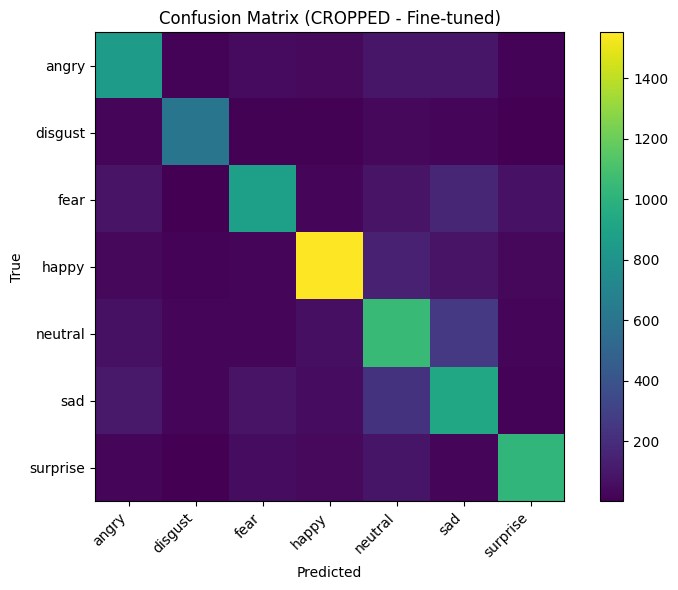

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model("best_cropped_ft.keras")

test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print("Test accuracy:", test_acc)

y_true, y_pred = [], []
for x, y in test_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Confusion Matrix (CROPPED - Fine-tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


In [14]:
import tensorflow as tf

model = tf.keras.models.load_model("best_cropped_ft.keras")
model.save("/content/emotion_model_ft_v1.keras")
print("✅ Saved:", "/content/emotion_model_ft_v1.keras")


✅ Saved: /content/emotion_model_ft_v1.keras


In [15]:
model.export("/content/emotion_model_ft_v1_savedmodel")
print("✅ Exported:", "/content/emotion_model_ft_v1_savedmodel")


Saved artifact at '/content/emotion_model_ft_v1_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134820094952272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134820094967632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134822525854416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134820094952080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134818256930192: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  134818256929808: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  134818256932880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134818256929616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134818256930576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134818256930000: TensorSpec(shape=()

In [16]:
from google.colab import files
files.download("/content/emotion_model_ft_v1.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import tensorflow as tf

model = tf.keras.models.load_model("best_cropped_ft.keras")

# retrouver backbone
backbone = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnet" in layer.name.lower():
        backbone = layer
        break
print("Backbone:", backbone.name)

backbone.trainable = True

# Déverrouille plus qu'avant
FINE_TUNE_LAYERS = 220
for l in backbone.layers[:-FINE_TUNE_LAYERS]:
    l.trainable = False

# LR plus bas (important)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks_ft2 = [
    tf.keras.callbacks.ModelCheckpoint("best_cropped_ft2.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1),
]

history_ft2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    class_weight=class_weight,
    callbacks=callbacks_ft2
)


Backbone: efficientnetv2-b0
Epoch 1/8
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7725 - loss: 0.6071
Epoch 1: val_accuracy improved from -inf to 0.74327, saving model to best_cropped_ft2.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 202s 126ms/step - accuracy: 0.7725 - loss: 0.6070 - val_accuracy: 0.7433 - val_loss: 0.7133 - learning_rate: 1.0000e-05
Epoch 2/8
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7772 - loss: 0.5883
Epoch 2: val_accuracy improved from 0.74327 to 0.74772, saving model to best_cropped_ft2.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 168s 123ms/step - accuracy: 0.7772 - loss: 0.5883 - val_accuracy: 0.7477 - val_loss: 0.7037 - learning_rate: 1.0000e-05
Epoch 3/8
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7828 - loss: 0.5760
Epoch 3: val_accuracy did not improve from 0.74772

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 170s 124ms/step - accuracy: 0.7828 - loss: 0.5760 - val_a

In [18]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

model2 = tf.keras.models.load_model("best_cropped_ft2.keras")

test_loss, test_acc = model2.evaluate(test_ds, verbose=1)
print("✅ Test accuracy FT2:", test_acc)

y_true, y_pred = [], []
for x, y in test_ds:
    p = model2.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7267 - loss: 0.7479
✅ Test accuracy FT2: 0.7466981410980225
              precision    recall  f1-score   support

       angry     0.7270    0.7357    0.7313      1169
     disgust     0.8750    0.8575    0.8662       702
        fear     0.7692    0.6803    0.7220      1323
       happy     0.8845    0.8177    0.8498      1892
     neutral     0.6337    0.6756    0.6540      1529
         sad     0.5775    0.6764    0.6230      1443
    surprise     0.8612    0.8255    0.8430      1255

    accuracy                         0.7467      9313
   macro avg     0.7612    0.7527    0.7556      9313
weighted avg     0.7558    0.7467    0.7498      9313



In [19]:
import tensorflow as tf
m = tf.keras.models.load_model("best_cropped_ft2.keras")
m.save("/content/emotion_model_ft2.keras")
print("✅ Saved: /content/emotion_model_ft2.keras")


✅ Saved: /content/emotion_model_ft2.keras


In [21]:
import tensorflow as tf

def to_one_hot(x, y):
    y = tf.one_hot(y, depth=num_classes)
    return x, y

train_ds_oh = train_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_oh   = val_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_oh  = test_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_oh = train_ds_oh.prefetch(tf.data.AUTOTUNE)
val_ds_oh   = val_ds_oh.prefetch(tf.data.AUTOTUNE)
test_ds_oh  = test_ds_oh.prefetch(tf.data.AUTOTUNE)


In [22]:
import tensorflow as tf

model = tf.keras.models.load_model("best_cropped_ft2.keras")

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # très petit LR
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.06),
    metrics=["accuracy"]
)

callbacks_ft3 = [
    tf.keras.callbacks.ModelCheckpoint("best_cropped_ft3.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True, verbose=1),
]

history_ft3 = model.fit(
    train_ds_oh,
    validation_data=val_ds_oh,
    epochs=4,
    class_weight=class_weight,
    callbacks=callbacks_ft3
)


Epoch 1/4
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7914 - loss: 0.8563
Epoch 1: val_accuracy improved from -inf to 0.75101, saving model to best_cropped_ft3.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 202s 126ms/step - accuracy: 0.7914 - loss: 0.8563 - val_accuracy: 0.7510 - val_loss: 0.9447
Epoch 2/4
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7907 - loss: 0.8394
Epoch 2: val_accuracy did not improve from 0.75101
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 167s 121ms/step - accuracy: 0.7907 - loss: 0.8394 - val_accuracy: 0.7486 - val_loss: 0.9414
Epoch 3/4
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7912 - loss: 0.8242
Epoch 3: val_accuracy did not improve from 0.75101
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 168s 122ms/step - accuracy: 0.7912 - loss: 0.8242 - val_accuracy: 0.7456 - val_loss: 0.9392
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [23]:
import numpy as np
from sklearn.metrics import classification_report

model3 = tf.keras.models.load_model("best_cropped_ft3.keras")

test_loss, test_acc = model3.evaluate(test_ds_oh, verbose=1)
print("✅ Test accuracy FT3:", test_acc)

y_true, y_pred = [], []
for x, y in test_ds:
    p = model3.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(tf.argmax(p, axis=1).numpy().tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


292/292 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.7240 - loss: 0.9980
✅ Test accuracy FT3: 0.7485235929489136
              precision    recall  f1-score   support

       angry     0.7298    0.7322    0.7310      1169
     disgust     0.8951    0.8390    0.8662       702
        fear     0.7822    0.6757    0.7251      1323
       happy     0.8809    0.8251    0.8521      1892
     neutral     0.6279    0.6841    0.6548      1529
         sad     0.5791    0.6826    0.6266      1443
    surprise     0.8667    0.8287    0.8473      1255

    accuracy                         0.7485      9313
   macro avg     0.7659    0.7525    0.7576      9313
weighted avg     0.7587    0.7485    0.7519      9313



In [24]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.10),
], name="augment")

base = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)

modelS = tf.keras.Model(inputs, outputs)

modelS.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacksS1 = [
    tf.keras.callbacks.ModelCheckpoint("best_v2s.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

modelS.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,340,327 (77.59 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [25]:
histS1 = modelS.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacksS1
)


Epoch 1/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.3452 - loss: 1.7032
Epoch 1: val_accuracy improved from -inf to 0.45696, saving model to best_v2s.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 250s 161ms/step - accuracy: 0.3453 - loss: 1.7031 - val_accuracy: 0.4570 - val_loss: 1.4640 - learning_rate: 0.0010
Epoch 2/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4260 - loss: 1.5225
Epoch 2: val_accuracy improved from 0.45696 to 0.46937, saving model to best_v2s.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 214s 156ms/step - accuracy: 0.4260 - loss: 1.5225 - val_accuracy: 0.4694 - val_loss: 1.4237 - learning_rate: 0.0010
Epoch 3/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4361 - loss: 1.4998
Epoch 3: val_accuracy improved from 0.46937 to 0.48378, saving model to best_v2s.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 206s 150ms/step - accuracy: 0.4361 - loss: 1.4998 - val_accuracy: 0.4838 - val_loss: 1.3882 - learning_rate: 0.0010
Epoch 4/10
1372/1372 ━━━━━━━━━━

In [26]:
import tensorflow as tf

modelS = tf.keras.models.load_model("best_v2s.keras")

# retrouver backbone
backbone = None
for layer in modelS.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnet" in layer.name.lower():
        backbone = layer
        break
print("Backbone:", backbone.name)

backbone.trainable = True

# déverrouille les dernières couches
FINE_TUNE_LAYERS = 160
for l in backbone.layers[:-FINE_TUNE_LAYERS]:
    l.trainable = False

modelS.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacksS2 = [
    tf.keras.callbacks.ModelCheckpoint("best_v2s_ft.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1),
]

histS2 = modelS.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight,
    callbacks=callbacksS2
)


Backbone: efficientnetv2-s
Epoch 1/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.4205 - loss: 1.5412
Epoch 1: val_accuracy improved from -inf to 0.58003, saving model to best_v2s_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 376s 237ms/step - accuracy: 0.4205 - loss: 1.5412 - val_accuracy: 0.5800 - val_loss: 1.1320 - learning_rate: 2.0000e-05
Epoch 2/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5496 - loss: 1.2140
Epoch 2: val_accuracy improved from 0.58003 to 0.63165, saving model to best_v2s_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 315s 229ms/step - accuracy: 0.5496 - loss: 1.2140 - val_accuracy: 0.6317 - val_loss: 0.9965 - learning_rate: 2.0000e-05
Epoch 3/10
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6079 - loss: 1.0619
Epoch 3: val_accuracy improved from 0.63165 to 0.67013, saving model to best_v2s_ft.keras
1372/1372 ━━━━━━━━━━━━━━━━━━━━ 313s 228ms/step - accuracy: 0.6079 - loss: 1.0619 - val_accuracy: 0.6701 - val_loss: 0.9015 - learning_

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

bestS = tf.keras.models.load_model("best_v2s_ft.keras")

test_loss, test_acc = bestS.evaluate(test_ds, verbose=1)
print("✅ Test accuracy V2S:", test_acc)

y_true, y_pred = [], []
for x, y in test_ds:
    p = bestS.predict(x, verbose=0)
    y_true.extend(y.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


292/292 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.7123 - loss: 0.8047
✅ Test accuracy V2S: 0.7468055486679077
              precision    recall  f1-score   support

       angry     0.7316    0.6903    0.7104      1169
     disgust     0.8300    0.8903    0.8591       702
        fear     0.7573    0.6629    0.7070      1323
       happy     0.8555    0.8451    0.8503      1892
     neutral     0.6296    0.7070    0.6661      1529
         sad     0.6505    0.6126    0.6310      1443
    surprise     0.7991    0.8622    0.8294      1255

    accuracy                         0.7468      9313
   macro avg     0.7505    0.7529    0.7505      9313
weighted avg     0.7476    0.7468    0.7460      9313



In [28]:
import tensorflow as tf

bestS = tf.keras.models.load_model("best_v2s_ft.keras")
bestS.save("/content/emotion_faces_v2s_final.keras")
print("✅ Modèle final sauvegardé")


✅ Modèle final sauvegardé


In [30]:
from google.colab import files

files.download("/content/emotion_faces_v2s_final.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>